In [57]:
#!pip install pyreadstat
import pyreadstat
import pandas as pd

df_path = "anes_timeseries_2020_stata_20210324.dta"

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [59]:
# Read file
df, meta = pyreadstat.read_dta(df_path)
print(len(df['V200001'].unique())) # number of unique people who responded, should be equal to length of df before filtering

# Keep only observations from respondents who say they intend to vote
print("Shape before filtering:", df.shape)
df = df[df['V201032'].isin([1.])]
print("Shape after filtering:", df.shape)

# Define the outcome of interest as 1 if the voter will vote for the Republicans, 0 otherwise
df = df[(df['V201033'] != -9) & (df['V201033'] != -8)]
trump_votes_count = df['V201033'].value_counts().get(2.0, 0)
print("Number of people who prefer Trump:", trump_votes_count)

# Create binary outcome variable 
Y = df['V201033'].apply(lambda x: 1 if x == 2.0 else 0)

# Filter out missing values from X_df based on indices of Y
X_df = pd.DataFrame({
    'Age': pd.to_numeric(df['V201507x'], errors='coerce'),
    'College_Degree_or_Higher': df['V201510'].apply(lambda x: 1 if x in ["6. Bachelor's degree (e.g. BA, AB, BS)", "7. Master's degree (e.g. MA, MS, MEng, MEd, MSW, MBA)", "4. Associate degree in college - occupational/vocational", "5. Associate degree in college - academic"] else 0),
    'Trust_in_Media': df['V201377'].apply(lambda x: 1 if (x == 5 or x == 4 or x == 3) else 0),
})

# Ensure consistent indices and drop missing values
X_df = X_df.dropna()
Y = Y.dropna()
Y = Y.loc[X_df.index]
print(f'size of Y: {len(Y)}')
print(f'size of X_df: {len(X_df)}')

# Create design matrix
X_with_intercept = sm.add_constant(X_df)
print(f'size of X_with_intercept: {len(X_with_intercept)}')

8280
Shape before filtering: (8280, 1381)
Shape after filtering: (7272, 1381)
Number of people who prefer Trump: 3016
size of Y: 7138
size of X_df: 7138
size of X_with_intercept: 7138


In [60]:
# Fit the model 
model = sm.Logit(Y, X_with_intercept['const']).fit()

Optimization terminated successfully.
         Current function value: 0.681095
         Iterations 4


In [61]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                V201033   No. Observations:                 7138
Model:                          Logit   Df Residuals:                     7137
Method:                           MLE   Df Model:                            0
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:               1.663e-10
Time:                        16:53:06   Log-Likelihood:                -4861.7
converged:                       True   LL-Null:                       -4861.7
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3124      0.024    -13.038      0.000      -0.359      -0.265


In [62]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

In [63]:
# Number of simulations
n_simulations = 1000

# Simulate beta coefficients:

# on the log-odds scale
simulated_base_log_odds = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

# on the odds scale
simulated_base_odds = np.exp(simulated_base_log_odds)

# on the probability scale
simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# simulations array
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

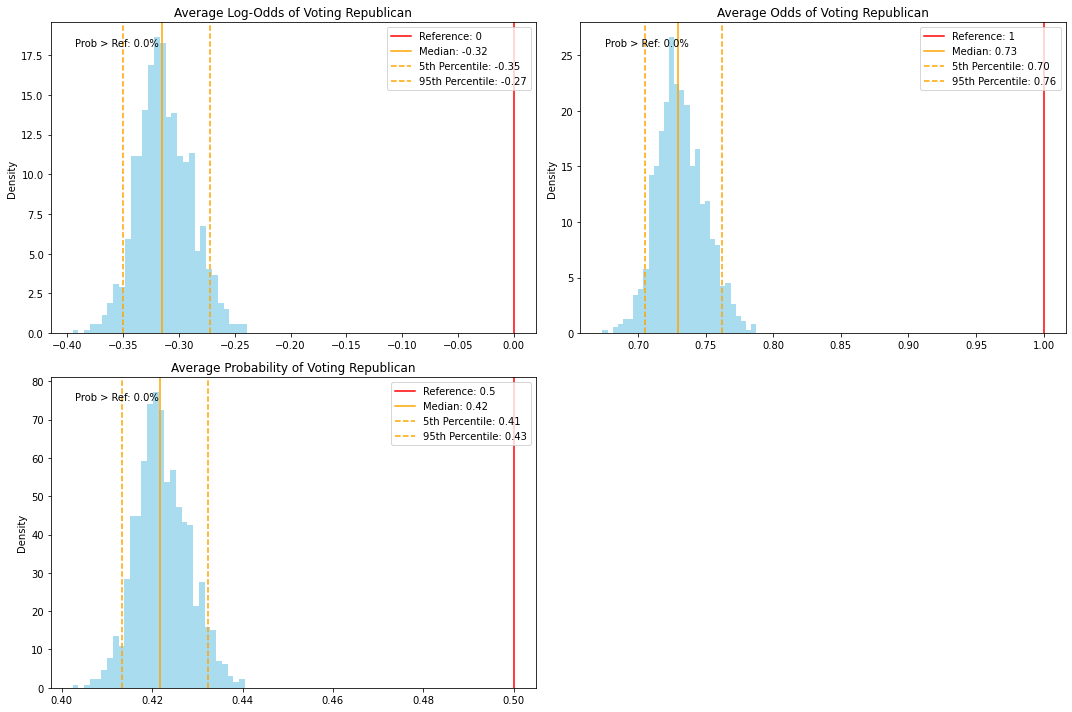

In [64]:
# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis=0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of Voting Republican')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

In [66]:
aic = model.aic
print("AIC:", aic)

AIC: 9725.307198723003


In [65]:
def logistic_regression(X, y, test_size=0.2, random_state=None):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize logistic regression model
    log_reg_model = LogisticRegression()

    # Fit the model on the training data
    log_reg_model.fit(X_train, y_train)

    # Predictions on the test data
    y_pred = log_reg_model.predict(X_test)

    # Evaluate the model
    classification_rep = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return classification_rep, conf_matrix, accuracy

classification_rep, conf_matrix, accuracy = logistic_regression(X_with_intercept, Y, test_size=0.3, random_state=420)
print("Classification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)
print(f'Accuracy:  {accuracy:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1206
           1       0.71      0.81      0.76       936

    accuracy                           0.77      2142
   macro avg       0.77      0.78      0.77      2142
weighted avg       0.78      0.77      0.77      2142


Confusion Matrix:
[[899 307]
 [178 758]]
Accuracy:  0.7736
